This notebook aims at estimating the convergence rate of the fastPLN algorithm with respect to $p$. We will take a sample of size $n= 2000$. 

In [1]:
from scipy.linalg import toeplitz
from fastPLNmodels.utils import build_block_Sigma, sample_PLN, Poisson_reg
import matplotlib.pyplot as plt

In [2]:
import torch
torch.cuda.is_available()

False

In [3]:
device = torch.device('cpu')

threshold : 0.0005


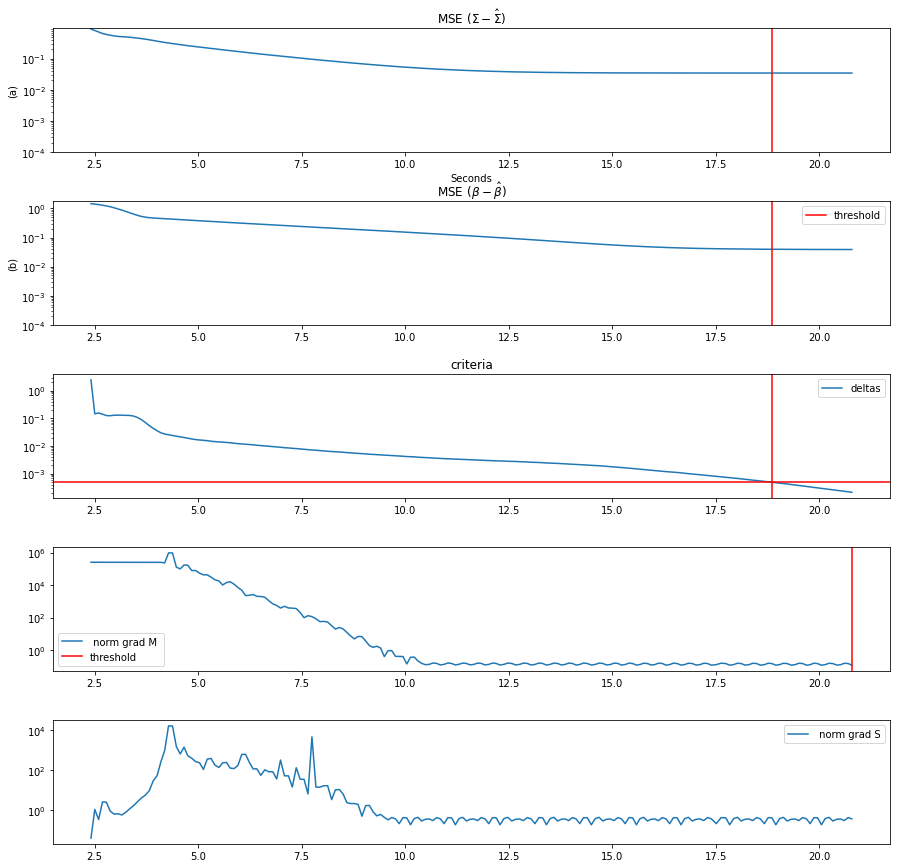

In [213]:
def show(model,name_doss , threshold, threshold_bis, save = False):
    '''
    function to show one model. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.Will also plot the norm of the gradients and 
    the variance of the weights used for the importance sampling. 
    
    args : 
        'model' MC_PLNPCA object where you have called model.fit_IMPS()
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. It can also save the figure if save = True. 
    '''
    print('threshold :', threshold)
    first = np.argmin(np.array(model.deltas)>threshold)
    sec = np.argmin(np.array(model.norm_grad_M)>threshold_bis)
    if first == 0 : 
        first = len(model.running_times)-1
    if sec == 0 : 
        sec = len(model.running_times)- 1
        
    first = min(sec, first)
    
    first_time = model.running_times[first]
    sec_time = model.running_times[sec]
    fig,ax = plt.subplots(5,1,figsize = (15,15))

    #MSE of Sigma
    abscisse = model.running_times
    plt.subplots_adjust(hspace = 0.4)
    
    
    ax[0].plot(abscisse, model.MSE_Sigma_list)
    ax[0].set_title(r'MSE $(\Sigma- \hat \Sigma)$')
    ax[0].set_xlabel('Seconds')
    ax[0].set_ylim(ymin= 1e-4)
    ax[0].set_ylabel('(a)')
    ax[0].axvline(first_time, c = 'red', label = 'threshold')
    ax[0].set_yscale('log')
    
    #MSE of beta. 
    ax[1].plot(abscisse, model.MSE_beta_list)
    ax[1].set_title(r'MSE $(\beta - \hat \beta)$') 
    ax[1].set_yscale('log')
    ax[1].set_ylim(ymin= 1e-4)
    ax[1].set_ylabel('(b)')
    ax[1].axvline(first_time, c = 'red', label = 'threshold')
    ax[1].legend()
    
    
    # plot the L1 norm of the gradients. 
    ax[2].plot(abscisse, model.deltas, label = 'deltas')
    ax[2].set_title('criteria')
    ax[2].legend()
    
    ax[2].axvline(first_time, c = 'red', label = 'threshold')
    ax[2].axhline(threshold, c = 'red', label = 'threshold')
    ax[2].set_yscale('log')
    
    ax[3].plot(abscisse, model.norm_grad_M, label = ' norm grad M ')
    ax[3].set_yscale('log')
    ax[3].axvline(sec_time, c = 'red', label = 'threshold')
    ax[3].legend()
    
    ax[4].plot(abscisse, model.norm_grad_S, label = ' norm grad S')
    ax[4].set_yscale('log')
    ax[4].legend()
    
    '''
    
    #here we plot the variance for the 3 integrals. We set a threshold from which we consider that the integral 
    # is misestimate if the variance of the weights is above. 
    threshold = 0.9
    # integral for beta 
    ax[4].scatter( np.linspace(0,abscisse[-1], model.var_weights['beta'].shape[0]), model.var_weights['beta'],s = 1, label = 'variance of the weights for beta', c = 'black')
    percentage_bad_beta = np.sum(model.var_weights['beta']>threshold)/(model.var_weights['beta'].shape[0])
    ax[4].axhline(model.acc, c = 'red', label = 'reference')
    ax[4].set_title('Variance beta, pourcentage of bad approximations : '+ str(np.round(percentage_bad_beta,3)))
    ax[4].set_yscale('log')
    ax[4].legend()
    '''
    if save : 
        plt.savefig(name_doss)
    plt.show()
    
show(model,'',threshold = 1/(2*p**(11/11)), threshold_bis = 0.1)


In [301]:
import math
import time 

import numpy as np
import torch
import seaborn as sns
import scipy.linalg as SLA 
torch.set_default_dtype(torch.float64)

#get the device
if torch.cuda.is_available(): 
    device = torch.device('cuda') 
else : 
    device = torch.device('cpu')
def ELBO(Y, O,covariates ,M ,S ,Sigma ,beta):
    '''Compute the ELBO (Evidence LOwer Bound. See the doc for more details 
    on the computation. It is actually not called in the .fit method, since we 
    are computing the gradients ourselves, so that we don't need to compute the 
    ELBO. 
    
    Args: 
        Y: torch.tensor. Samples with size (n,p)
        0: torch.tensor. Offset, size (n,p)
        covariates: torch.tensor. Covariates, size (n,d)
        M: torch.tensor. Variational parameter with size (n,p)
        S: torch.tensor. Variational parameter with size (n,p)
        Sigma: torch.tensor. Model parameter with size (p,p)
        beta: torch.tensor. Model parameter with size (d,p)
    Returns: 
        torch.tensor of size 1, with a gradient. The ELBO. 
    '''
    n,p = Y.shape
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    tmp = torch.sum( torch.multiply(Y, OplusM)  
                     -torch.exp(OplusM+SrondS/2) 
                     +1/2*torch.log(SrondS)
                   )
    DplusMmoinsXB2 = torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(Sigma), 
                                        DplusMmoinsXB2
                                    )
                          )
    tmp-= n/2*torch.log(torch.det(Sigma))
    return tmp





In [264]:
tol = [None, 2]
tol[0] = 4
tol

[4, 2]

In [265]:
def RMSE(mat):
    return torch.sqrt(torch.mean(mat**2))

In [266]:
d = 2
n = 2000;  p = 200
q = 20

In [278]:
#torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,q))/3 #+ 0.5*torch.eye(p)
#true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
#true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.randn((d, p))*1.5

covariates = torch.randn((n,d))/1
O =  0+torch.zeros((n,p))
Y, Z,_  = sample_PLN(Sigma_sampling,true_beta, O, covariates)
Y = torch.from_numpy(Y)

In [279]:
torch.max(Y)

tensor(8314375)

<AxesSubplot:>

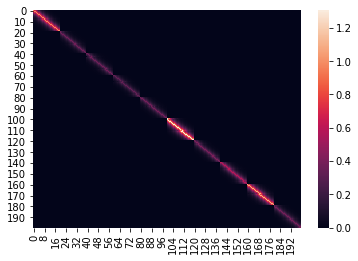

In [280]:
sns.heatmap(Sigma_sampling)

In [302]:
model = fastPLN()
model.fit(Y,O,covariates, 200, verbose = True)

Iteration number:  0
-------UPDATE-------
Delta :  2.462279113651019
Iteration number:  10
-------UPDATE-------
Delta :  0.13537990231100144
Iteration number:  20
-------UPDATE-------
Delta :  0.02777103368221425
Iteration number:  30
-------UPDATE-------
Delta :  0.01738514492680155
Iteration number:  40
-------UPDATE-------
Delta :  0.013325618669195006
Iteration number:  50
-------UPDATE-------
Delta :  0.00827011607478508
Iteration number:  60
-------UPDATE-------
Delta :  0.0024928465736344108
Last delta: 0.0024928465736344108, last_RMSE_M : 1.3849814941025518 reached in 61 iterations


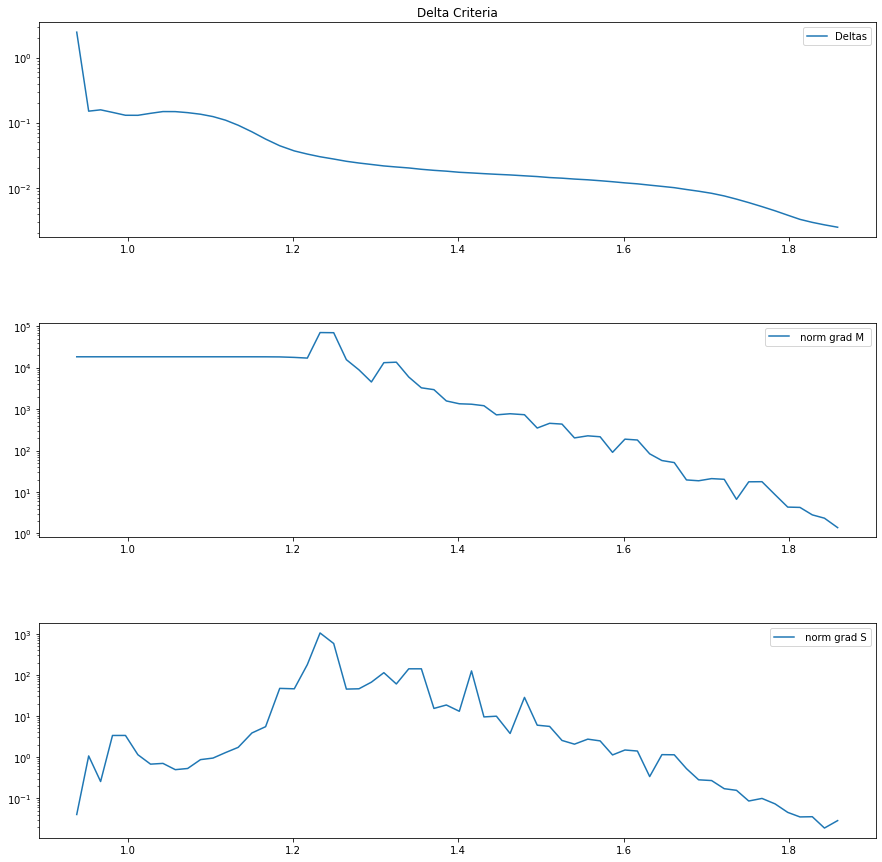

In [303]:
model.show()

In [ ]:
1/(2*500)

threshold : 0.001


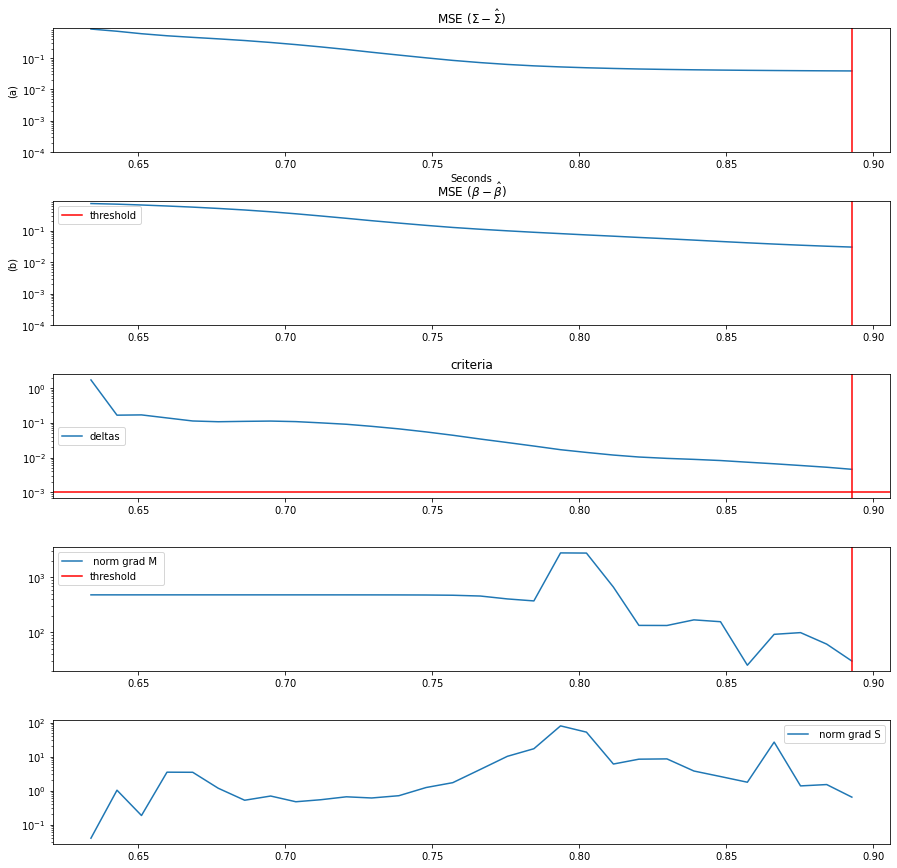

 p :  100
time took  0.8926515579223633
threshold : 0.001


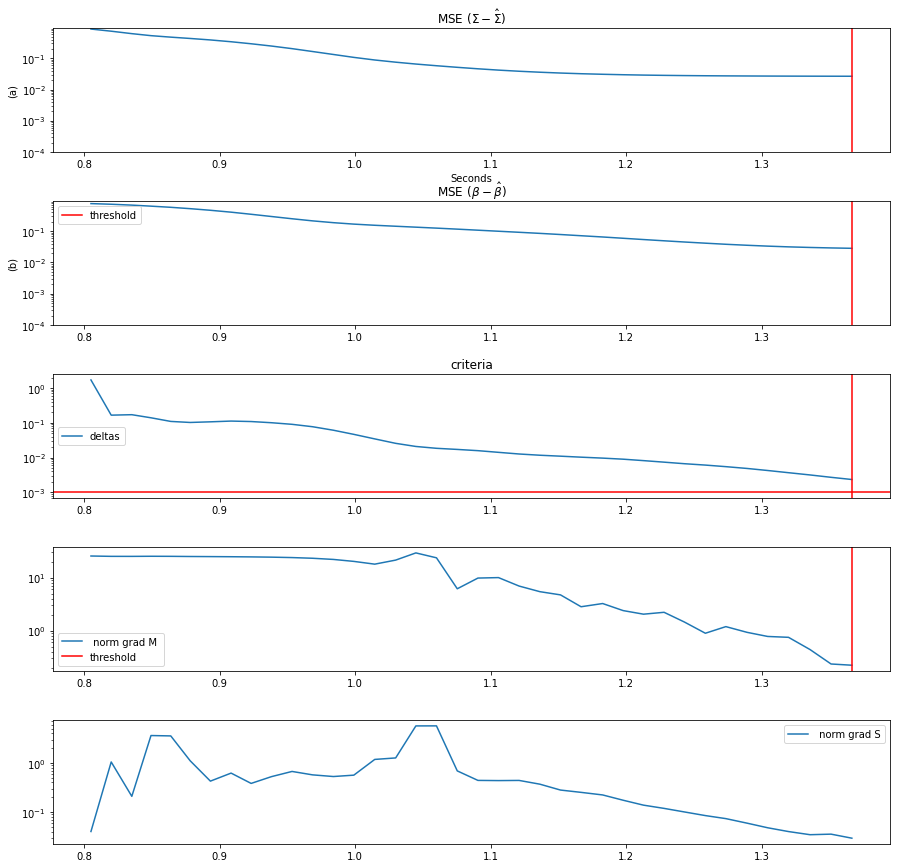

 p :  200
time took  1.3665211200714111
threshold : 0.001


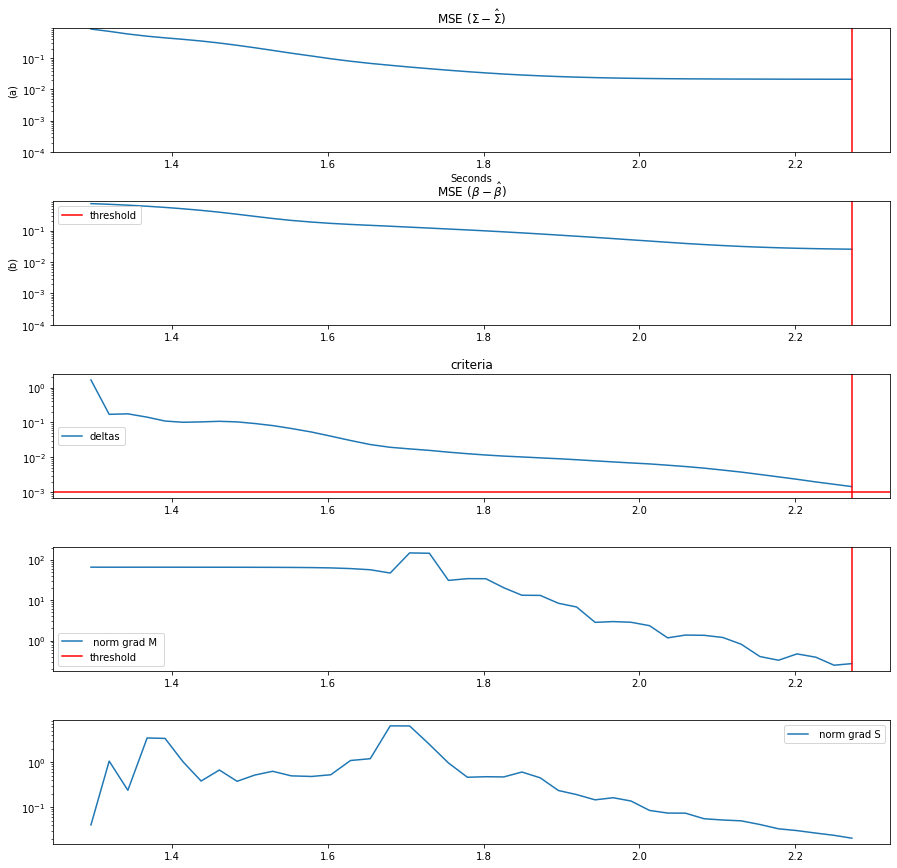

 p :  300
time took  2.272611379623413
threshold : 0.001


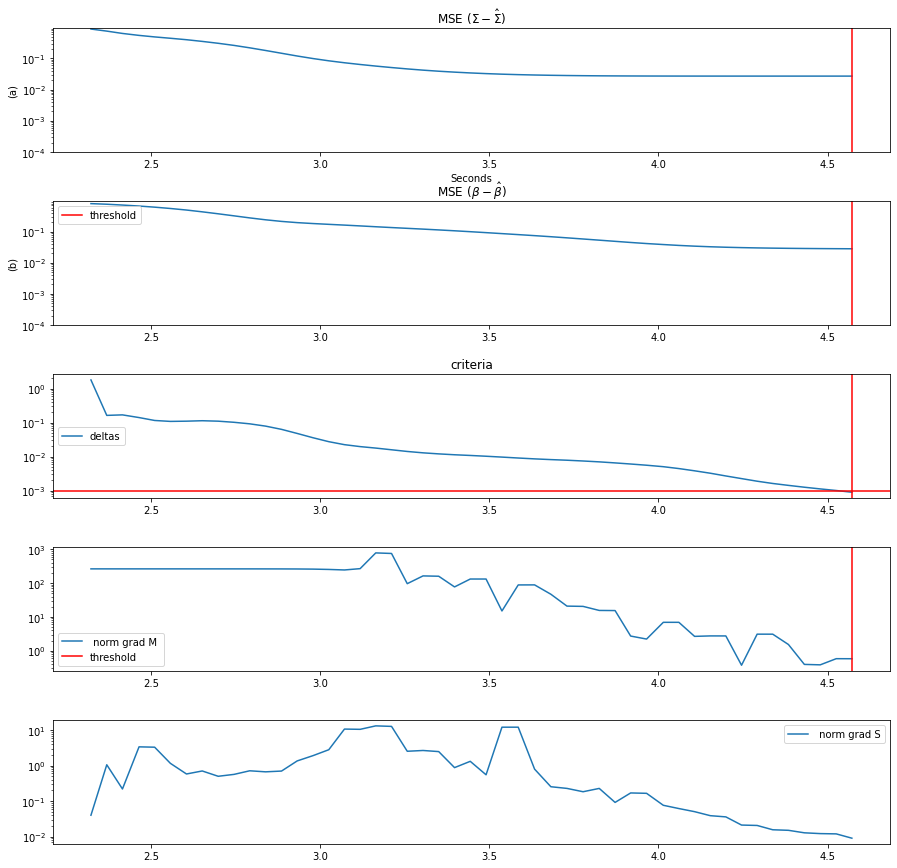

 p :  500
time took  4.571875095367432
threshold : 0.000625


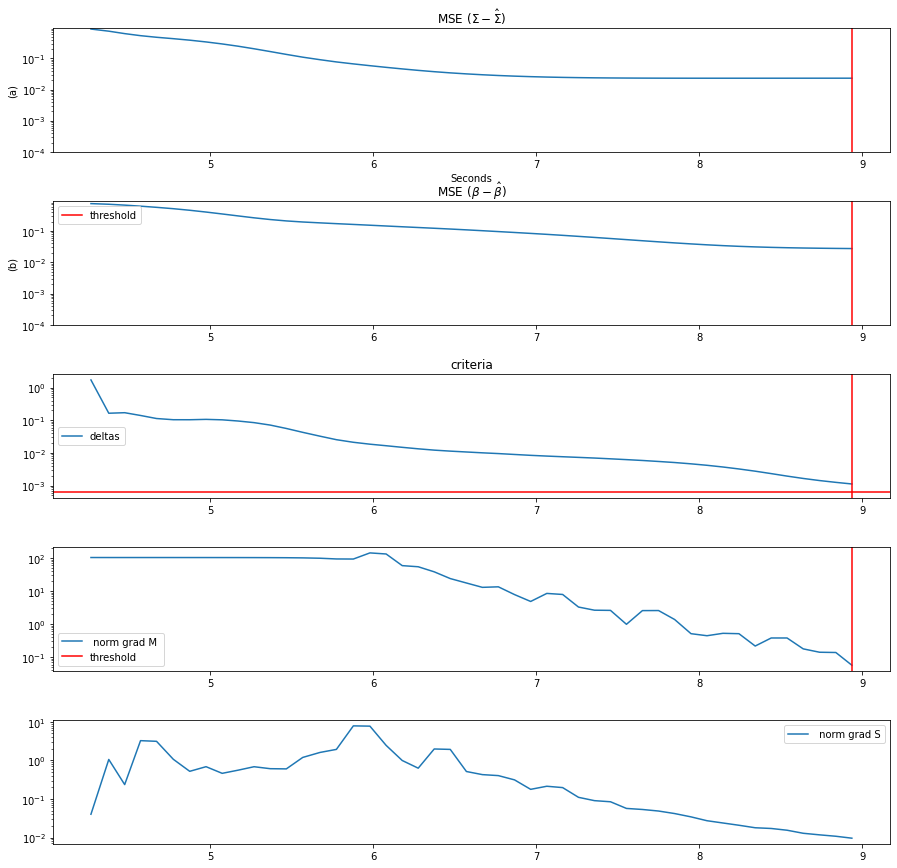

 p :  800
time took  8.937339782714844
threshold : 0.0005


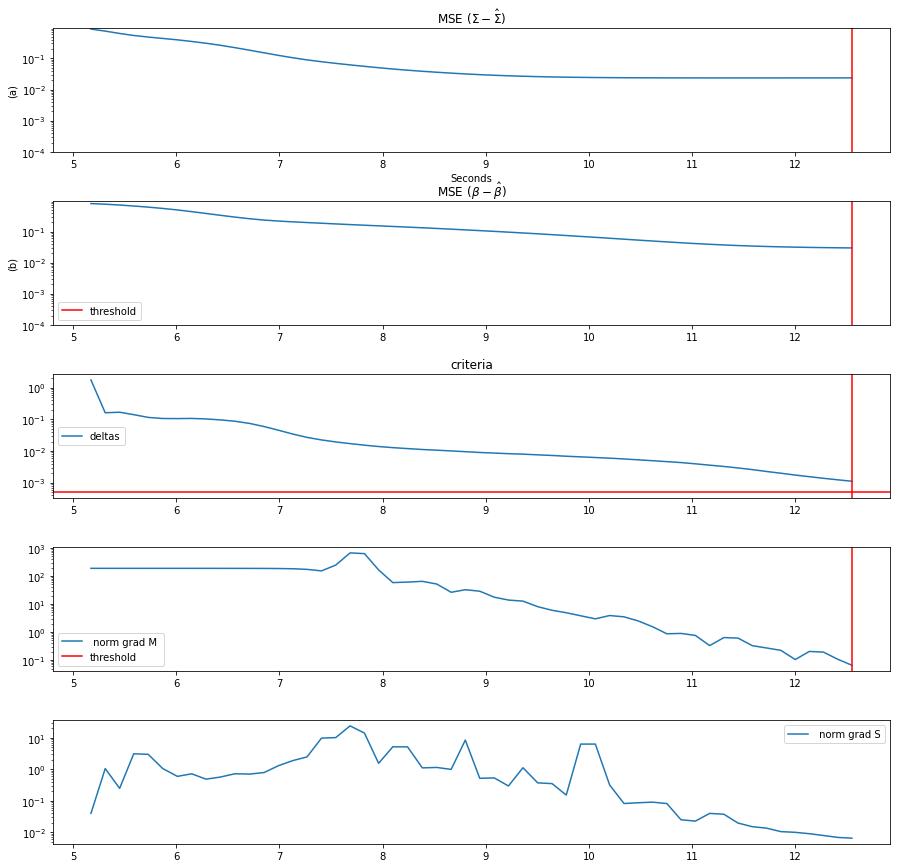

 p :  1000
time took  12.546895503997803
threshold : 0.0003846153846153846


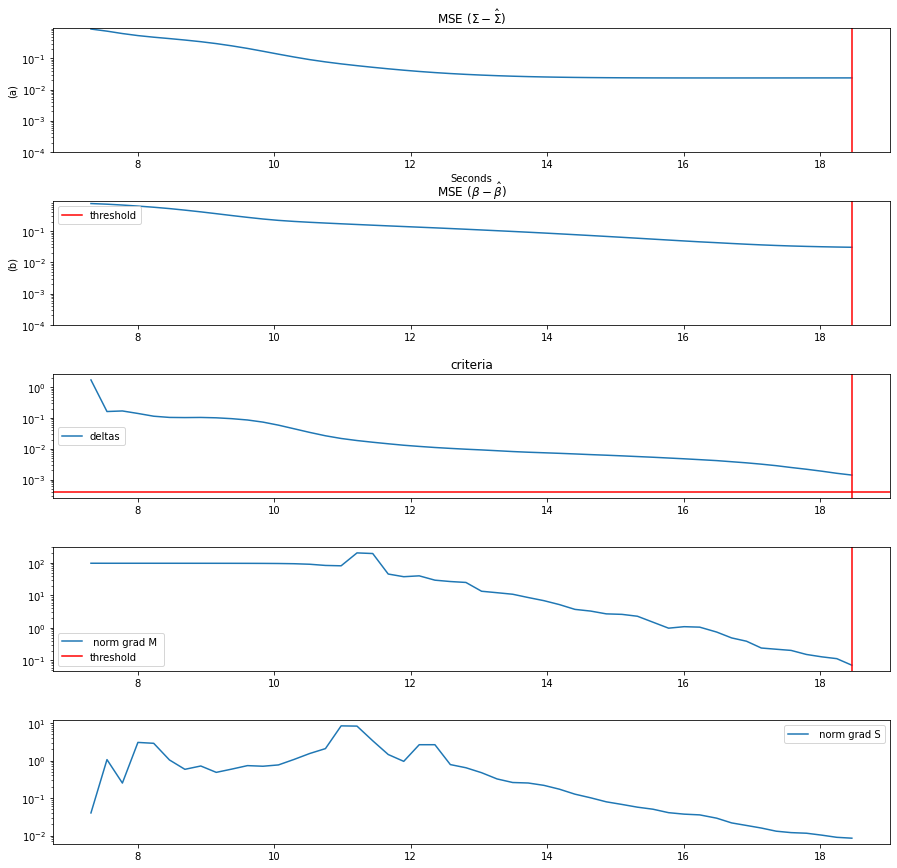

 p :  1300
time took  18.465537786483765
threshold : 0.0003333333333333333


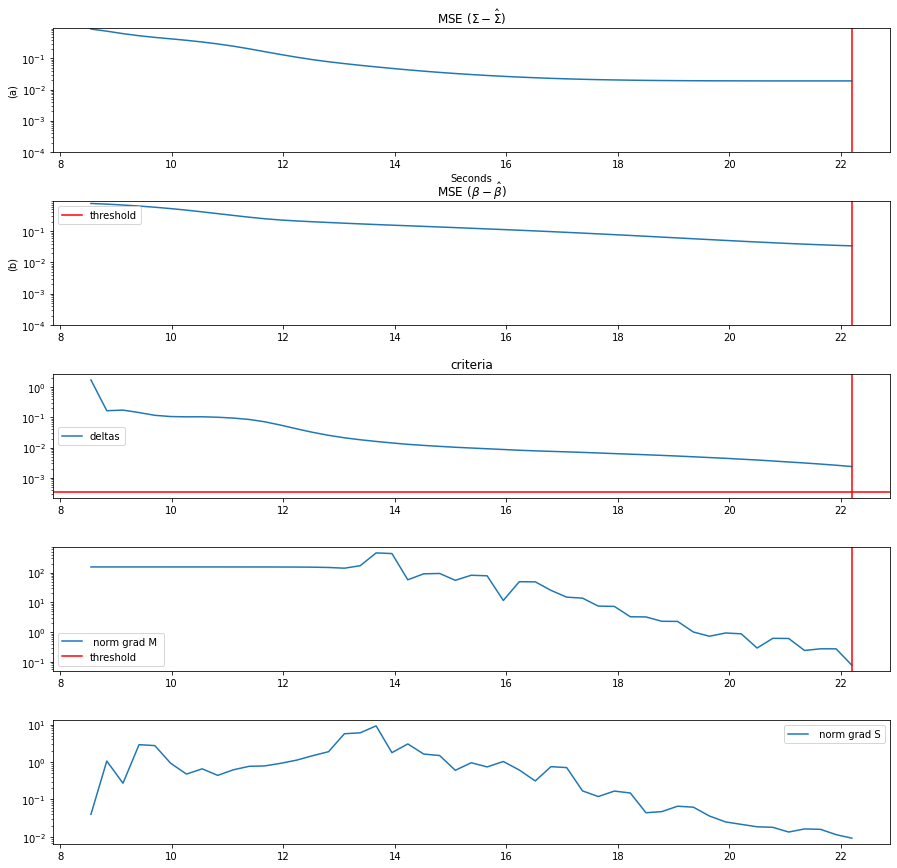

 p :  1500
time took  22.196177005767822


In [230]:
ps = [100,200,300,500,800,1000,1300,1500]
times = list()
models = list()
for p_ in ps: 
    p = p_
    #torch.manual_seed(0)
    Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,q))/3 #+ 0.5*torch.eye(p)
    #true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
    #true_Sigma_sampling = true_C@(true_C.T)
    true_beta =torch.randn((d, p))*0.8
    covariates = torch.randn((n,d))/1
    O =  0+torch.zeros((n,p))
    Y, Z,_  = sample_PLN(Sigma_sampling,true_beta, O, covariates)
    Y = torch.from_numpy(Y)
    model = fastPLN()
    model.fit(Y,O,covariates, 120, verbose = False, tolerance = 1/(2*p))
    show(model, '',threshold = min(0.001, 1/(2*p)), threshold_bis = 0.1)
    times.append(model.running_times[-1])
    models.append(model)
    print(' p : ', p)
    print('time took ', times[-1])
    

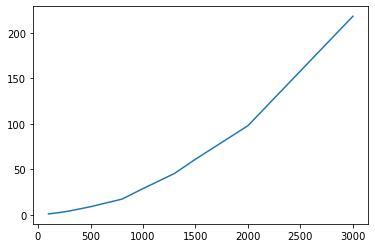

In [8]:
ps = [100,200,300,500,800,1000,1300,1500,2000,3000]#
times = [1.11,2.55,4.35,9.03,17.37,28.907,45.56,61.2,98,218.18]
plt.plot(ps,times)

<AxesSubplot:>

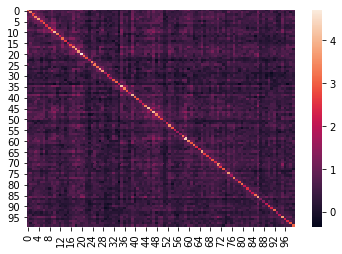

In [152]:
n_a = 0
n_b = 100

sns.heatmap(model.Sigma[n_a:n_b,n_a:n_b])

<AxesSubplot:>

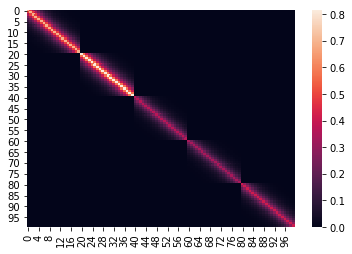

In [153]:
sns.heatmap(Sigma_sampling[n_a:n_b,n_a:n_b])